<span style="color:black;">Related servicer file:</span> <span style="color:green;">real-ros-mujoco/ur3-mujoco-servicer-ros-v1</span>

In [1]:
TB_DIR = "TB-ddpg-ink-useless/"

In [2]:
TCP_PORT = 15015

In [3]:
from __future__ import print_function

In [4]:
import numpy as np
import socket
import json

class tcp_env():
    def __init__(self, tcp_port):
        self.s=socket.socket(socket.AF_INET,socket.SOCK_STREAM)

        self.s.connect(('127.0.0.1',tcp_port))

        print( self.s.recv(1024).decode())

        data = { 'type' : 'init' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        self.state_dim = data_json["state_dim"]
        self.action_dim = data_json["action_dim"]
        self.DoF = data_json["DoF"]

        # s.send('exit')
        # s.close()        
        
    def  reset(self):
        data = { 'type' : 'reset' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        state = np.array( data_json["state"] )
        return state
    def step(self, action):
        
        data = { 'type' : 'step', 'action' : action.tolist() } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        state = np.array( data_json["state"] )
        r = data_json["reward"]
        d = data_json["done"]
        info = data_json["info"]
        
        return state, r, d, info
    def close_tcp(self):
        print(" close tcp ... ")
        data = { 'type' : 'close' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        self.s.close()        


In [5]:
env = tcp_env( tcp_port = TCP_PORT )

Welcome!


In [12]:
env.close_tcp()

 close tcp ... 


In [6]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
import numpy as np
import gym

from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm

LR_A = 0.001
LR_C = 0.002
GAMMA = 0.9
TAU = 0.01
MEMORY_CAPACITY = 30000
BATCH_SIZE = 32

class DDPG:
    def __init__(self, env):
        self.s_dim = env.state_dim
        self.a_dim = self.action_dim = env.action_dim    
        self.max_steps = 500
        self.min_trajectory = 30
        self.max_trajectory = 60
        
        self.a_bound = 1.0

        self.build_nn()
        self.train_method()
        self.sess = tf.Session()

        tf.summary.FileWriter(TB_DIR, self.sess.graph) # tensorboard --logdir='logs'

        if 1:
            self.sess.run(tf.global_variables_initializer())
        else:
            ckpt = tf.train.get_checkpoint_state("model-save-ddpg-ink-ros-3DoF-v1")  
            if ckpt and ckpt.model_checkpoint_path:  
                tf.train.Saver().restore(self.sess, ckpt.model_checkpoint_path)
                print( "Load model ..." )
        
        self.pointer = 0
        self.memory = np.zeros((MEMORY_CAPACITY, self.s_dim * 2 + self.a_dim + 1), dtype=np.float32)
        
        self.adjust_norm = 0
        
    def build_nn(self):

        self.is_training = tf.placeholder(tf.bool, name="is_training")
        self.is_training2 = tf.placeholder(tf.bool, name="is_training2")
        
        self.s = tf.placeholder(tf.float32, [None, self.s_dim], 's')
        self.s_ = tf.placeholder(tf.float32, [None, self.s_dim], 's_')
        self.r = tf.placeholder(tf.float32, [None, 1], 'r')
        
        with tf.variable_scope("batch_norm_s"):
            self.norm_s = tf.layers.batch_normalization(self.s , training=self.is_training )
            
        with tf.variable_scope("batch_norm_s_"):
            self.norm_s_ = tf.layers.batch_normalization(self.s_ , training=self.is_training2 )
        
        with tf.variable_scope("eval"):
            self.a = self.build_a_nn( self.norm_s , scope = "actor", trainable = True)
            self.q = self.build_c_nn( self.norm_s , self.a, scope = "critic", trainable = True)
            
        with tf.variable_scope("target"):
            self.a_target = self.build_a_nn( self.norm_s_ , scope = "actor", trainable = False)
            self.q_target = self.build_c_nn( self.norm_s_ , self.a_target, scope = "critic", trainable = False)

        self.ea_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="eval/actor")
        self.ec_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="eval/critic")
        self.ta_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="target/actor")
        self.tc_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="target/critic")
        
        self.params_norm_s = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="batch_norm_s")
        self.params_norm_s_ = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="batch_norm_s_")
        
        self.feed_norm = [[tf.assign(p_n_s_, p_n_s)]
            for p_n_s_, p_n_s in zip( self.params_norm_s_, self.params_norm_s )]
        
        self.soft_replace = [[tf.assign(ta, (1-TAU)*ta+TAU*ea), tf.assign(tc, (1-TAU)*tc+TAU*ec)]
            for ta, ea, tc, ec in zip(self.ta_params, self.ea_params, self.tc_params, self.ec_params)]
        
    def train_method(self):

        c_loss = tf.losses.mean_squared_error(labels = (self.r + GAMMA*self.q_target), predictions = self.q)
        self.c_learn = tf.train.AdamOptimizer(LR_C).minimize( c_loss, name="adam-c", var_list = self.ec_params )

        self.a_learn = tf.train.AdamOptimizer(LR_A).minimize( - tf.reduce_mean(self.q), name="adam-a", var_list = self.ea_params )
        
    def build_c_nn(self, s, a, scope, trainable):
        # Critic: Q-leaning
        with tf.variable_scope(scope):
            
            net_1 = tf.layers.dense( tf.concat( axis=1, values=[ a,s ], name="concat" ), 60, activation = tf.nn.relu, name="a-s", trainable=trainable )
    
#             net_2 = tf.layers.dense( net_1, 30, activation = tf.nn.relu, name="net_2", trainable=trainable )
            q = tf.layers.dense(net_1, 1, name="q", trainable = trainable)
            
        return q
    def build_a_nn(self, s, scope, trainable):
        # Actor: DPG
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 30, activation = tf.nn.relu, name = 's1', trainable = trainable)
            
            a = tf.layers.dense(l1, self.a_dim, activation = tf.nn.tanh, name = 'a1', trainable = trainable)     
            
        return a #tf.multiply(a, self.a_bound, name = "scaled_a")  
        
    def action(self, s):

        if self.pointer < ( self.max_steps*self.max_trajectory ) :
            a = np.clip( np.random.normal( [0]*self.action_dim , 1.0) , -self.a_bound, self.a_bound )   
        else:
            a = self.sess.run(self.a, { self.is_training:False, self.s: s[np.newaxis, :]})[0]        
            a = np.clip(np.random.normal(a, 0.1), -self.a_bound, self.a_bound )
        return a
    
    def store_memory(self, s, s_, r, a):
        trans = np.hstack((s,a,[r],s_))
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1

        if self.pointer > (self.min_trajectory*self.max_steps) :
            self.learn()
            
    def learn(self):
        memory_size = min(self.pointer, MEMORY_CAPACITY)
        method = 0
        # Soft Parameter Update
        if method == 0:
            self.sess.run(self.soft_replace)



#         if self.adjust_norm:
#             self.sess.run(self.a_learn, { self.is_training:True, self.s: bs})
#             self.sess.run(self.feed_norm)
#         else:
#             self.sess.run(self.a_learn, { self.is_training:False, self.s: bs})
        
#         self.sess.run(self.c_learn, { self.is_training:False, self.is_training2:False, self.s: bs, self.a: ba, self.r: br, self.s_: bs_})

        for _ in range(5):    
            if method == 1:
                self.sess.run(self.soft_replace)
            
            indices = np.random.choice( memory_size , size = BATCH_SIZE)
            bt = self.memory[indices, :]
            bs = bt[:, :self.s_dim]
            ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
            br = bt[:, -self.s_dim-1: -self.s_dim]
            bs_ = bt[:, -self.s_dim:]
            self.sess.run(self.c_learn, { self.is_training:False, self.is_training2:False, self.s: bs, self.a: ba, self.r: br, self.s_: bs_})

        indices = np.random.choice( memory_size , size = BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim-1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]
            
        self.sess.run(self.a_learn, { self.is_training:False, self.s: bs})


In [8]:
# env = gym.make( "Pendulum-v0" )

In [9]:
agent = DDPG( env )

In [10]:
max_step_ep = 500
r_save = []

In [11]:
a_scope = 0.02

#### Train

In [12]:
max_learning_ep = 100

for learning_ep in range(max_learning_ep):
    print("learning_ep: ", learning_ep)
    
    s = env.reset()
    r_all = 0
    for step_ep in range(max_step_ep):
        a = agent.action(s)
        s_,r,d,_ = env.step( a*a_scope )
        agent.store_memory(s, s_, r, a)
        r_all += r
        s = s_
        if d:
            break
    print("r_all: ", r_all)
    r_save.append( r_all )

learning_ep:  0
r_all:  -212.592767859
learning_ep:  1
r_all:  -310.230877534
learning_ep:  2
r_all:  -350.603589709
learning_ep:  3
r_all:  -156.966091349
learning_ep:  4
r_all:  -267.023604705
learning_ep:  5
r_all:  -227.741625414
learning_ep:  6
r_all:  -237.492440426
learning_ep:  7
r_all:  -274.376731892
learning_ep:  8
r_all:  -258.663382064
learning_ep:  9
r_all:  -297.178117605
learning_ep:  10
r_all:  -188.281772157
learning_ep:  11
r_all:  -284.671711469
learning_ep:  12
r_all:  -208.010702535
learning_ep:  13
r_all:  -250.099607794
learning_ep:  14
r_all:  -206.514777048
learning_ep:  15
r_all:  -251.954082169
learning_ep:  16
r_all:  -173.000510581
learning_ep:  17
r_all:  -292.4361646
learning_ep:  18
r_all:  -280.69901513
learning_ep:  19
r_all:  -237.200646734
learning_ep:  20
r_all:  -345.650442102
learning_ep:  21
r_all:  -314.551640067
learning_ep:  22
r_all:  -323.063896969
learning_ep:  23
r_all:  -314.601114756
learning_ep:  24
r_all:  -263.961791816
learning_ep: 

In [14]:
from tqdm import trange

In [15]:
print( "with learning cycles: ", len(r_save) )

max_learning_ep = 200

for _ in range(150000):
    delay_time_trange = np.random.rand( 100 )
for learning_ep in trange(max_learning_ep):
    
    s = env.reset()
    r_all = 0
    for step_ep in range(max_step_ep):
        a = agent.action(s)
        s_,r,d,_ = env.step( a*a_scope )
        agent.store_memory(s, s_, r, a)
        r_all += r
        s = s_
        if d:
            break
    r_save.append( r_all )

with learning cycles:  100


100%|██████████| 200/200 [27:18<00:00,  8.19s/it]


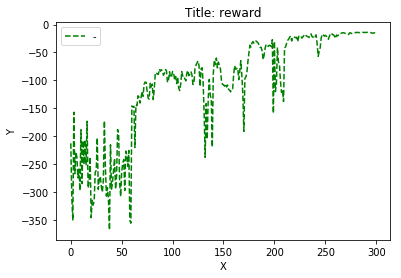

In [16]:
xypoints = r_save

plt.plot(np.array(xypoints).reshape(-1), 'g--', label='-')
plt.title('Title: reward')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left')
plt.show()

In [12]:
s = (np.random.rand(3)-0.5)*10

In [18]:
self=agent

In [19]:
s

array([ 0.00870691, -0.00792007, -0.00617578,  0.00687384, -0.00858311,
       -0.00550336, -0.05870445, -1.58777399, -1.5733516 , -0.2986    ,
        0.19425   ,  0.39555   ])

In [20]:
norm_s = self.sess.run(self.norm_s, { self.is_training:False, self.s: s[np.newaxis, :]})[0]

In [21]:
norm_s

array([ 0.00870256, -0.00791612, -0.0061727 ,  0.0068704 , -0.00857882,
       -0.00550061, -0.05867511, -1.5869807 , -1.5725654 , -0.2984508 ,
        0.19415294,  0.39535236], dtype=float32)

In [22]:
norm_s_ = self.sess.run(self.norm_s_, { self.is_training2:False, self.s_: s[np.newaxis, :]})[0]

In [23]:
norm_s_

array([ 0.00870256, -0.00791612, -0.0061727 ,  0.0068704 , -0.00857882,
       -0.00550061, -0.05867511, -1.5869807 , -1.5725654 , -0.2984508 ,
        0.19415294,  0.39535236], dtype=float32)

#### Test without action noise and bound

In [17]:
for learning_ep in range( 1 ):
    print("learning_ep: ", learning_ep)
    
    s = env.reset()
    r_all = 0
    act_save = []
    dis_save = []
    vel_save = []
    for step_ep in range(max_step_ep):
#         env.render()
        
        self = agent
        a = self.sess.run(self.a, { self.is_training:False, self.s: s[np.newaxis, :]})[0]
        
        act_save.append( a )
        s_,r,d,info = env.step( a*a_scope )
        vel_save.append( s_[:6] )
        dis_save.append( info )
        r_all += r
        s = s_
        if d:
            break
    print("r_all: ", r_all)


learning_ep:  0
r_all:  -14.9459187214


In [18]:
act_save_2 = np.array( act_save )

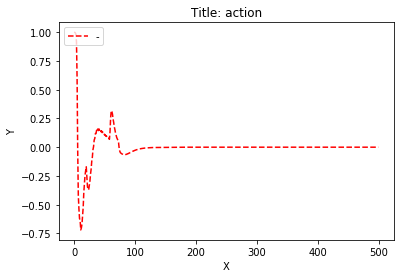

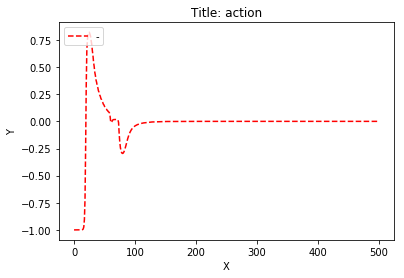

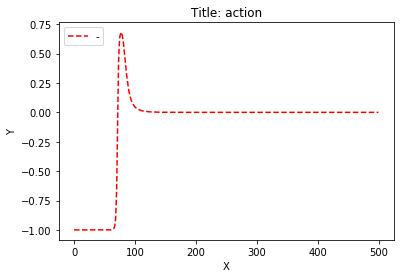

In [19]:
for i in range( env.DoF ):
    xypoints = act_save_2[:,i]

    plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
    plt.title('Title: action')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')
    plt.show()

In [20]:
vel_save_2 = np.array( vel_save )

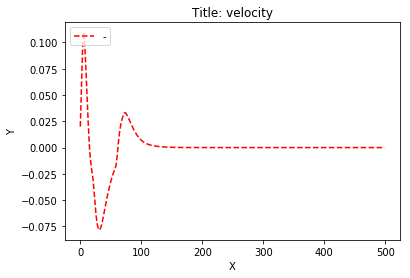

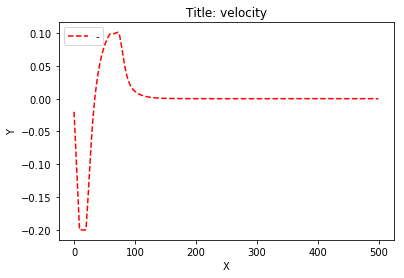

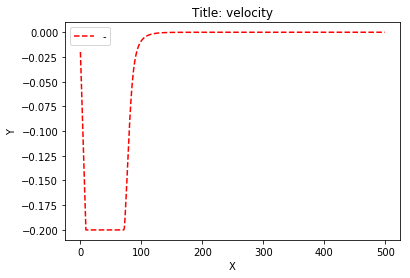

In [21]:
for i in range( env.DoF ):
    xypoints = vel_save_2[:,i]

    plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
    plt.title('Title: velocity')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')
    plt.show()

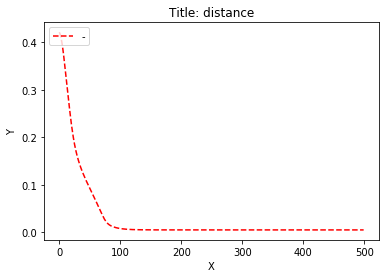

In [22]:
xypoints = dis_save

plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
plt.title('Title: distance')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left')
plt.show()

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
x = 1.0

a = []
m_step = 500
for _ in range( m_step*300 - 30000 ):
    x *= 0.99995
    a.append( x )

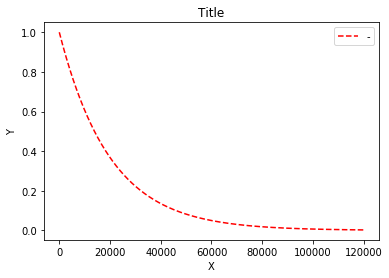

In [3]:
xypoints = a

plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
plt.title('Title')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.random.normal(a, self.var)

In [23]:

a = []
for _ in range( 100 ):
    x = np.random.normal(0, 1.0)
    a.append( x )

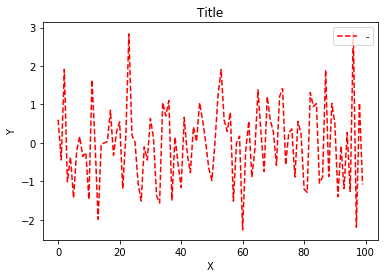

In [24]:
xypoints = a

plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
plt.title('Title')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

In [31]:
tf.train.Saver().save( agent.sess, "model-save-ddpg-ink-ros-3DoF-v1/model.ckpt" ) 

'model-save-ddpg-ink-ros-3DoF-v1/model.ckpt'